### Set up google colab and unzip train data

based on: https://github.com/pranayKD/faster_rcnn_colab_pytorch/blob/master/Faster_RCNN.ipynb

In [1]:
# Check available GPU
!nvidia-smi -L
!nvidia-smi

# https://cloud.google.com/gpu

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [2]:
# Set up google drive in google colab

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


### Import Libraries

In [3]:
import random
import os
import math
import xml.etree.ElementTree as ET
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image,ImageFilter, ImageEnhance
import cv2
import torch.optim as optim
from torchvision.ops import nms
from tqdm import tqdm
from torchvision.ops import box_iou
import time

from collections import OrderedDict
from torchsummary import summary

### Define Model Hyper Parameters

In [4]:
select_classes = {'apples'} # Only training for these classes

anchor_scale = torch.FloatTensor([8,16,32])  
anchor_ratio = torch.FloatTensor([0.5,1,2])  
conversion_scale = 16
input_image_height = 500
input_image_width = 500
num_anchors_sample = 256

# Non Maximum Suppression hyper parameters
nms_threshold = 0.7       # only consider anchors with IOU < nms_threshold
nms_num_train_pre = 12000 # Select top nms_num_train_pre anchors to apply nms on 
nms_num_train_post = 2000 # number of proposal regions after NMS
nms_num_test_pre = 6000   # For test 
nms_num_test_post = 300   # For test
nms_min_size = 16         # only consider anchors as valid while applying nms if ht and wt < nms_min_size


#proposal target (pt) hyper parameters
pt_n_sample = 128  #Number of samples to sample from roi
pt_pos_ratio = 0.25 #the number of positive examples out of the n_samples
pt_pos_iou_threshold  = 0.5 #Min overlap required between roi and gt for considering positive label (object)
pt_neg_iou_threshold = 0.5 # below this value marks as negative


#ROI pooling
roi_size = (7,7)

# RPN loss 
rpn_loss_lambda = 1 # same is used in the decider loss


# Number of classes
num_classes = 2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu



### Import the Data and corresponding functions

##### Data augmentation

In [5]:
# Random blur on training image
def random_blur(img):
  if random.random() < 0.5:
    return img
  
  rad = random.choice([1,2])
  img = img.filter(ImageFilter.BoxBlur(radius=rad))
  return img


# Random brightness, contrast, satutration and hue
def random_color(img):
  if random.random() < 0.1:
    return img

  img = transforms.ColorJitter(brightness=(0.5,2.0), contrast=(0.5,2.0), saturation=(0.5,2.0), hue=(-0.25,0.25))(img)
  return img

# Random horizontal flip
def random_flip(img, gt_box):
  if random.random() < 0.5:
    return img,gt_box

  img = transforms.RandomHorizontalFlip(p=1)(img)
  temp = (gt_box[:,1]).copy()
  gt_box[:,1] = img.size[0] - gt_box[:,0] #x1
  gt_box[:,0] = img.size[0] - temp #x2

  return img, gt_box


# Random crop on image
def random_crop(img, gt_box, labels):
  if random.random() < 0.5:
    return img,gt_box,labels
  width, height = img.size
  select_w = random.uniform(0.6*width, width)
  select_h = random.uniform(0.6*height, height)

  start_x = random.uniform(0,width - select_w)
  start_y = random.uniform(0,height - select_h)

  left = start_x
  upper = start_y
  right = start_x + select_w
  bottom = start_y + select_h

  gt_box_copy = gt_box.copy()

  gt_box_copy[gt_box_copy[:,0] < left, 0] = left
  gt_box_copy[gt_box_copy[:,1] > right, 1] = right
  gt_box_copy[gt_box_copy[:,2] < upper, 2] = upper
  gt_box_copy[gt_box_copy[:,3] > bottom, 3] = bottom

  final_gt_box = []
  final_labels = []

  for i in range((gt_box_copy.shape[0])):
    if (((gt_box_copy[i,1] - gt_box_copy[i,0])/(gt_box[i,1]-gt_box[i,0])) < 0.5):
      continue
    if (((gt_box_copy[i,3] - gt_box_copy[i,2])/(gt_box[i,3] - gt_box[i,2])) < 0.5):
      continue
    final_gt_box.append(gt_box_copy[i])
    final_labels.append(labels[i])

  if len(final_gt_box) == 0:
    return img,gt_box,labels

  final_gt_box = np.array(final_gt_box)
  final_gt_box[:,0] = final_gt_box[:,0] - left
  final_gt_box[:,1] = final_gt_box[:,1] - left
  final_gt_box[:,2] = final_gt_box[:,2] - upper
  final_gt_box[:,3] = final_gt_box[:,3] - upper

  return img.crop((left, upper, right, bottom)), final_gt_box, final_labels

In [6]:
transform = transforms.Compose(
    [transforms.Resize((input_image_height,input_image_width)),
     transforms.ToTensor(),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

inv_normalize = transforms.Normalize(
   mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
   std=[1/0.229, 1/0.224, 1/0.225]
)

##### Create Pytorch Dataset and Dataloader


In [7]:
class apple_data(Dataset):
    def __init__(self, img_dir,desc_dir,type_list, isTrain, transform = None):
        super().__init__()
        self.img_dir = img_dir
        self.desc_dir = desc_dir
        self.type_list = type_list
        self.isTrain = isTrain
        self.transform = transform


        self.img_names = []
        self.img_descs = []
        for img in sorted(os.listdir(img_dir)):
          if img[:-4] in self.type_list:
            self.img_names.append(img)
        
        for desc in sorted(os.listdir(desc_dir)):
          if desc[:-4] in  self.type_list:
            self.img_descs.append(desc)
       
        self.img_names = [os.path.join(img_dir, img_name) for img_name in self.img_names]
        self.img_descs = [os.path.join(desc_dir, img_desc) for img_desc in self.img_descs]             
        
        self.loc_gts = []
        self.loc_labels = []
        self.final_img_names = []
        
        for i, file in enumerate(self.img_descs):

          gt = []
          loc_lab = []

          data = pd.read_csv(file)

          for j in range(len(data)):
            c_x = data["c-x"]
            c_x = c_x[j]
            c_y = data["c-y"]
            c_y = c_y[j]
            radius = data["radius"]
            radius = radius[j]
            loc1 = c_x - radius
            loc2 = c_x + radius
            loc3 = c_y - radius
            loc4 = c_y + radius
            lab = 1

            # if ht or width is less than 10, ignore the gt box
            if ((loc2 - loc1) < 10 ) or ((loc4 - loc3) < 10):
               continue

            gt.append([int(loc1),int(loc2),int(loc3),int(loc4)])
            loc_lab.append(lab)
          
          if self.isTrain:
            if (len(gt) == 0):
              continue
          
          self.loc_gts.append(gt)
          self.loc_labels.append(loc_lab)
          self.final_img_names.append(self.img_names[i])

        self.img_names = self.final_img_names
             
    def __len__(self):
        return len(self.img_names)
    
    def __getitem__(self,idx):
        img_name = self.img_names[idx]
        img = Image.open(img_name)

        arr_loc_gts = np.array(self.loc_gts[idx])
        label = self.loc_labels[idx]

        if self.isTrain:
          img = random_blur(img)
          img = random_color(img)
          img,arr_loc_gts = random_flip(img,arr_loc_gts)
          img,arr_loc_gts,label = random_crop(img,arr_loc_gts,label)
        
        img_h_pre = img.size[1]
        img_w_pre = img.size[0]
        
        if self.transform:
            img = self.transform(img)
            
        img_h_post = img.shape[1]
        img_w_post = img.shape[2]
        
        height_ratio = img_h_post/img_h_pre
        width_ratio = img_w_post/img_w_pre
    
        arr_loc_gts[:,0] = arr_loc_gts[:,0]*width_ratio
        arr_loc_gts[:,1] = arr_loc_gts[:,1]*width_ratio
        arr_loc_gts[:,2] = arr_loc_gts[:,2]*height_ratio
        arr_loc_gts[:,3] = arr_loc_gts[:,3]*height_ratio
                        
        gts = (arr_loc_gts).tolist()
        
        
        return img, gts, label

##### Load in the saved dataloaders

In [8]:
train_loader = torch.load("drive/My Drive/Deep Learning/CS4240-Project/Dataloader_save/train_loader.pt")
validation_loader = torch.load("drive/My Drive/Deep Learning/CS4240-Project/Dataloader_save/valid_loader.pt")
test_loader = torch.load("drive/My Drive/Deep Learning/CS4240-Project/Dataloader_save/test_loader.pt")

### Function for visualizing the network

In [9]:
# Given input image, draw rectangles as specified by gt_box and pred_box and display
def visalize_network(img, train, gt_input, pred_box_rpn, pred_box_faster_rcnn, pred_box = [], save_image=''):
    if train: 
      fig, axs = plt.subplots(1, 3, figsize = (30, 10))
    else:
      fig, axs = plt.subplots(1, 4, figsize = (32, 8))

    transform_img = inv_normalize(img[0]).permute(1,2,0).to('cpu').numpy()
    blank_image = np.zeros((transform_img.shape[0],transform_img.shape[1],3), np.uint8)
    transform_img_input = transform_img.copy()
    transform_img_faster_rcnn = transform_img.copy()
    transform_img_output = transform_img.copy()
    
    # Input
    for box in gt_input:
        x0, x1, y0, y1 = box
        cv2.rectangle(transform_img_input, (int(x0),int(y0)), (int(x1),int(y1)), color=(0, 255, 255), thickness=2)
    axs[0].imshow(transform_img_input)
    axs[0].title.set_text('Input Image')

    # RPN Output
    axs[1].imshow(blank_image)
    for i in range(len(pred_box_rpn)):
        x0, x1, y0, y1 = pred_box_rpn[i]
        axs[1].add_patch(patches.Rectangle((int(x0), int(y0)), int(x1)-int(x0), int(y1)-int(y0), linewidth=1, edgecolor='r', linestyle = '--', facecolor='none'))
    axs[1].title.set_text('Region Proposal Network')

    # Faster RCNN Ouput
    for box in pred_box_faster_rcnn:
        x0, x1, y0, y1 = box
        cv2.rectangle(transform_img_faster_rcnn, (int(x0), int(y0)), (int(x1), int(y1)), color=(255, 0, 0), thickness=1)
    axs[2].imshow(transform_img_faster_rcnn)
    axs[2].title.set_text('Faster R-CNN Output')

    # Output layer
    if not train:
      for box in pred_box:
          x0, x1, y0, y1 = box
          cv2.rectangle(transform_img_output, (int(x0), int(y0)), (int(x1), int(y1)), color=(255, 0, 0), thickness=2)
      axs[3].imshow(transform_img_output)
      axs[3].title.set_text('Fruit Detection')

    if save_image=='':
        plt.show()  
    else:
        plt.savefig(save_image + '.png')

### Faster RCNN backbone used - ZF model

In [10]:
class ZFNet(nn.Module):
    
    """    
    Args:
        in_channels: number of features of the input image ("depth of image")
        hidden_channels: number of hidden features ("depth of convolved images")
        out_features: number of features in output layer
    """


    def __init__(self):
        super(ZFNet, self).__init__()
        self.features  = nn.Sequential(OrderedDict([
        ('conv1' , nn.Conv2d(3, 96, kernel_size=7, stride=2, padding=3)),
        ('relu1', nn.ReLU()),
        ('lrn1' , nn.LocalResponseNorm(3, alpha=0.00005, beta=0.75)),
        ('max_pool1' , nn.MaxPool2d(3, stride=2, padding=1)),
        ('conv2' , nn.Conv2d(96, 256, kernel_size=5, stride=2, padding=0)),
        ('relu2' , nn.ReLU()),
        ('lrn2' , nn.LocalResponseNorm(3, alpha=0.00005, beta=0.75)),
        ('max_pool2' , nn.MaxPool2d(3, stride=2, padding=1)),
        ('conv3' , nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1)),
        ('relu3' , nn.ReLU()),
        ('conv4' , nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1)),
        ('relu4' , nn.ReLU()),
        ('conv5' , nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1)),  
        ('relu5' , nn.ReLU()),
        ('max_pool3', nn.MaxPool2d(3, stride=2, padding=1)),
        ]))

        # Classifier
        self.classifier  = nn.Sequential(OrderedDict([
        ('fc1' , nn.Linear(12544,4096)),
				('relu6', nn.ReLU()),
        ('fc2', nn.Linear(4096,4096)),
				('relu7', nn.ReLU())
        ]))



In [11]:
# Base ZF model
def Faster_RCNN_ZF():
  model_ZF = ZFNet()
  ZF_feature_extracter  = model_ZF.features[:-1]
  ZF_classifier = model_ZF.classifier[:-1]
  
  return ZF_feature_extracter.to(device), ZF_classifier.to(device)

### Code for anchor generation on an image



In [12]:
# At point x,y from feature map, return 9 anchors on the input image scale
def generate_anchor_at_point(x,y):
    anchor_positions = torch.zeros((len(anchor_scale) * len(anchor_ratio),4))
    ctr_x = (x*2+1)*(conversion_scale/2)   # for x = 0, centre is 8 || for x = 1, centre is 24
    ctr_y = (y*2+1)*(conversion_scale/2)
    for ratio_idx in range(len(anchor_ratio)):
        for scale_idx in range(len(anchor_scale)):

            current = len(anchor_scale)*ratio_idx + scale_idx
            ratio = anchor_ratio[ratio_idx]
            scale = anchor_scale[scale_idx]

            h = conversion_scale*scale*torch.sqrt(ratio)
            w = conversion_scale*scale*torch.sqrt(1.0/ratio)
            
            anchor_positions[current,0] = ctr_x - w/2
            anchor_positions[current,1] = ctr_x + w/2
            anchor_positions[current,2] = ctr_y - h/2
            anchor_positions[current,3] = ctr_y + h/2
            
    return anchor_positions


# For features of scale (x,y) , generate all the anchor boxes
# input is height,width
# returns output on  x*y*9,4
def generate_anchors(x,y):
    anchor_positions = torch.zeros((x*y,len(anchor_scale) * len(anchor_ratio),4))
    for ctr_x in range(x):
        for ctr_y in range(y):
            current = ctr_x*y + ctr_y
            anchors = generate_anchor_at_point(ctr_x, ctr_y)
            anchor_positions[current] = anchors
    return anchor_positions.reshape(-1,4)

In [13]:
def get_valid_anchors(anchor_positions):
    valid_anchors_idx = torch.where((anchor_positions[:,0] >= 0) & 
             (anchor_positions[:,1] <= input_image_width) &
             (anchor_positions[:,2] >= 0) &
             (anchor_positions[:,3] <= input_image_height) )[0]

    anchor_positions = anchor_positions[valid_anchors_idx]
    return anchor_positions, valid_anchors_idx

    

### Getting intersection over union between 2 sets of boxes

In [14]:
def get_iou_matrix(anchor_positions, gt_boxes):
    iou_matrix = torch.zeros((len(anchor_positions), len(gt_boxes)))
    for idx,box in enumerate(gt_boxes):
        if isinstance(box,torch.Tensor):
          gt = torch.cat([box]*len(anchor_positions)).view(1,-1,4)[0]
        else:
          gt = torch.FloatTensor([box]*len(anchor_positions))
        max_x = torch.max(gt[:,0],anchor_positions[:,0])
        min_x = torch.min(gt[:,1],anchor_positions[:,1])
        max_y = torch.max(gt[:,2],anchor_positions[:,2])
        min_y = torch.min(gt[:,3],anchor_positions[:,3])
                
        invalid_roi_idx = (min_x < max_x) | (min_y < max_y)
        roi_area = (min_x - max_x)*(min_y - max_y)
        roi_area[invalid_roi_idx] = 0
        
        total_area = (gt[:,1] - gt[:,0])*(gt[:,3] - gt[:,2]) + \
                    (anchor_positions[:,1] - anchor_positions[:,0])*(anchor_positions[:,3]-anchor_positions[:,2]) - \
                     roi_area
                    
        iou = roi_area/(total_area + 1e-6)
        
        iou_matrix[:,idx] = iou
    return iou_matrix      
        

### After IOU calculation between anchors and gt boxes 

In [15]:
def get_max_iou_data(iou_matrix):
    gt_max_value = iou_matrix.max(axis=0)[0] #  for each gt box, this is the max iou
    
    #There is a possiblilty that corresponding to one gt box, there are multiple anchors with same iou (max value)
    all_gt_max = torch.where(iou_matrix == gt_max_value)[0]
    
    # For each anchor box, this is the max iou with any of the gt_box
    anchor_max_value = torch.max(iou_matrix, axis=1)[0]
    anchor_max = torch.argmax(iou_matrix, axis=1)
    
    return all_gt_max, anchor_max_value,anchor_max



# 1 - positive || 0 - negative || -1 - ignore
def get_anchor_labels(anchor_positions, all_gt_max, anchor_max_value):
    anchor_labels = torch.zeros(anchor_positions.shape[0])
    anchor_labels.fill_(-1.0)

    # for each anchor box, if iou with any of the gt_box is less than threshold, mark as 0
    anchor_labels[anchor_max_value < 0.3] = 0
    
    # If corresponding to any gt_box, the anchor has max iou -> mark as 1
    anchor_labels[all_gt_max] = 1.0
    
    # If for any anchor box, iou is greater than threshold for any of the gt_box, mark as 1
    anchor_labels[anchor_max_value > 0.7] = 1.0
    return anchor_labels



In [16]:
def sample_anchors_for_train(anchor_labels):
    pos_anchor_labels = torch.where(anchor_labels == 1)[0]
    num_pos = min(num_anchors_sample/2, len(pos_anchor_labels))
    pos_idx = np.random.choice(pos_anchor_labels,  int(num_pos), replace=False)

    neg_anchor_labels = torch.where(anchor_labels == 0)[0]
    num_neg = num_anchors_sample - num_pos
    neg_idx = np.random.choice(neg_anchor_labels, int(num_neg), replace=False)
    
    anchor_labels[:] = -1
    anchor_labels[pos_idx] = 1
    anchor_labels[neg_idx] = 0
    
    return anchor_labels



### bbox regression training data calculation


In [17]:
# Get delta between anchor_positions and gt_boxes
def delta_anchor_gt(anchor_positions, gt_boxes , anchor_max):

    anchor_gt_map =  gt_boxes[anchor_max]
    
    anchor_height = anchor_positions[:,3] - anchor_positions[:,2] # y2-y1
    anchor_width =  anchor_positions[:,1] - anchor_positions[:,0] # x2-x1
    anchor_ctr_y = anchor_positions[:,2] + anchor_height/2 # y1 + h/2
    anchor_ctr_x = anchor_positions[:,0] + anchor_width/2  # x1 + w/2
    
    gt_height = anchor_gt_map[:,3] - anchor_gt_map[:,2] # y2-y1
    gt_width =  anchor_gt_map[:,1] - anchor_gt_map[:,0] # x2-x1
    gt_ctr_y = anchor_gt_map[:,2] + gt_height/2 # y1 + h/2
    gt_ctr_x = anchor_gt_map[:,0] + gt_width/2  # x1 + w/2
    
    dx = (gt_ctr_x - anchor_ctr_x)/anchor_width
    dy = (gt_ctr_y - anchor_ctr_y)/anchor_height
    dw = torch.log(gt_width/anchor_width)
    dh = torch.log(gt_height/anchor_height)
    
    delta = torch.zeros_like(anchor_positions)
    delta[:,0] = dx
    delta[:,1] = dy
    delta[:,2] = dw
    delta[:,3] = dh
   
    return delta


# Given delta and anchor_positions, correct the anchors
def correct_anchor_positions(anchor_positions, delta):
    ha = anchor_positions[:,3] - anchor_positions[:,2] # y2-y1
    wa =  anchor_positions[:,1] - anchor_positions[:,0] # x2-x1
    ya = anchor_positions[:,2] + ha/2 # y1 + h/2
    xa = anchor_positions[:,0] + wa/2  # x1 + w/2
    
    dx = delta[:,0]
    dy = delta[:,1]
    dw = delta[:,2]
    dh = delta[:,3]
    
    
    x = dx*wa + xa
    y = dy*ha + ya
    w = torch.exp(dw)*wa
    h = torch.exp(dh)*ha
    
    correct_anchor_positions = torch.zeros_like(anchor_positions)
    
    correct_anchor_positions[:,0] = x - w/2
    correct_anchor_positions[:,1] = x + w/2
    correct_anchor_positions[:,2] = y - h/2
    correct_anchor_positions[:,3] = y + h/2
    
    return correct_anchor_positions

### Faster RCNN region proposal network defination

In [18]:
# Region Proposal Network

class Faster_RCNN_rpn(nn.Module):
    def __init__(self,extracter):
        super().__init__()
        self.extracter = extracter
        self.conv1 = nn.Conv2d(256, 512, 3, 1, 1)
        #class_conv1 checks corresponding to 1 point in feature map, 18 outputs. 
        # 9 anchors * (2) || anchor has object or not
        self.class_conv = nn.Conv2d(512, 2*len(anchor_scale)*len(anchor_ratio), 1, 1, 0)  
        #reg_conv1 checks corresponding to 1 point in feature map, 36 outputs. 
        # 9 anchors * (4) || anchor delta wrt ground truth boxes
        self.reg_conv = nn.Conv2d(512, 4*len(anchor_scale)*len(anchor_ratio), 1 ,1 , 0)

        self.conv1.weight.data.normal_(0, 0.01)
        self.conv1.bias.data.zero_()
        self.class_conv.weight.data.normal_(0, 0.01)
        self.class_conv.bias.data.zero_()
        self.reg_conv.weight.data.normal_(0, 0.01)
        self.reg_conv.bias.data.zero_()

        
        
    def forward(self,x):
        # input and output features of CNN are (nSamples x nChannels x Height x Width)
        
        features = self.extracter(x)
        conv1_out = F.relu(self.conv1(features))
        class_out = self.class_conv(conv1_out)
        reg_out = self.reg_conv(conv1_out)
        
        return features, class_out, reg_out

### Loss calculation - The same loss function is used for decider and RPN layer

In [19]:
# Loss for Region Proposal Netwoek
# Same loss is used for decider network

def RPN_loss(locs_preditct, class_predict, final_RPN_locs,final_RPN_class):
    final_RPN_locs = final_RPN_locs.to(device)
    final_RPN_class = final_RPN_class.long().to(device)
    
    # Cross entropy loss (check if the target is background or foreground)
    # Only consider labels with values 1 or 0. ignore -1
    class_loss = F.cross_entropy(class_predict, final_RPN_class, ignore_index=-1)

    #smooth L1 regression loss (calculate the loss in predicted locations of foreground)
    foreground_class_idx = (final_RPN_class > 0)
    locs_preditct  = locs_preditct[foreground_class_idx]
    final_RPN_locs = final_RPN_locs[foreground_class_idx]

 
    
    loc_loss = F.smooth_l1_loss(locs_preditct, final_RPN_locs) / (sum(foreground_class_idx)+1e-6)

    
    rpn_loss = class_loss + rpn_loss_lambda*loc_loss
  
    return rpn_loss

### Non Maximum Suppression

In [20]:
# Apply non max suppression on anchors

def non_max_suppression(correct_anchor_positions, class_score, img_h, img_w, isTrain):
    
    if isTrain:
        nms_pre = nms_num_train_pre
        nms_post = nms_num_train_post
    else :
        nms_pre = nms_num_test_pre
        nms_post = nms_num_test_post
    
    
    # Clip the anchors to image dimensions
    correct_anchor_positions[correct_anchor_positions[:,0] < 0,0] = 0 # x1
    correct_anchor_positions[correct_anchor_positions[:,1] > img_w,1] = img_w # x2
    correct_anchor_positions[correct_anchor_positions[:,2] < 0,2] = 0 # y1
    correct_anchor_positions[correct_anchor_positions[:,3] > img_h,3] = img_h # y2
    
    
    # Only keep anchors with height and width > nms_min_size
    anchor_width = correct_anchor_positions[:,1] - correct_anchor_positions[:,0]
    anchor_height = correct_anchor_positions[:,3] - correct_anchor_positions[:,2]


    
    keep_idx = (anchor_height > nms_min_size) & (anchor_width > nms_min_size)
    correct_anchor_positions = correct_anchor_positions[keep_idx]
    class_score = class_score[keep_idx]

    # Get the index of sorted class scores in descending order and select top nms_pre idx
    sorted_class_scores = torch.argsort(class_score, descending=True)
    pre_nms_idx = sorted_class_scores[:nms_pre]
    correct_anchor_positions = correct_anchor_positions[pre_nms_idx]
    class_score = class_score[pre_nms_idx]
    
    # Implementation for non max suppression
    change_format = torch.zeros_like(correct_anchor_positions)
    change_format[:,0] = correct_anchor_positions[:,0]
    change_format[:,1] = correct_anchor_positions[:,2]
    change_format[:,2] = correct_anchor_positions[:,1]
    change_format[:,3] = correct_anchor_positions[:,3]

    keep_anchors = nms(change_format.to('cpu'), class_score.clone().detach().to('cpu'), nms_threshold)

    keep_anchors = keep_anchors[:nms_post]
    correct_anchor_positions = correct_anchor_positions[keep_anchors]
    
    return correct_anchor_positions
        
        

### Assign classes to output of Region Proposal Network 

In [21]:
def assign_classification_anchors(extracted_roi, gt_boxes, gt_labels, isTrain):

    
    # calculate iou of rois and gt boxes
    iou_matrix = get_iou_matrix(extracted_roi, gt_boxes)
    
    # for each ROI, find gt with max iou and corresponding value
    gt_roi_argmax = iou_matrix.argmax(axis=1)
    gt_roi_max = iou_matrix.max(axis=1)[0]
    
    #If a particular ROI has max overlap with a gt_box, assign label of gt_box to roi
    assign_labels = gt_labels[gt_roi_argmax]
    
    num_pos = pt_n_sample*pt_pos_ratio
    pos_idx = torch.where(gt_roi_max > pt_pos_iou_threshold)[0]
    if isTrain:
      pos_idx = np.random.choice(pos_idx, int(min(len(pos_idx), num_pos)), replace=False)
    
    
    num_neg = pt_n_sample - len(pos_idx)
    neg_idx = torch.where(gt_roi_max < pt_neg_iou_threshold)[0]
    if isTrain:
      neg_idx = np.random.choice(neg_idx, int(min(len(neg_idx), num_neg)), replace=False)
    
    
    keep_idx = np.append(pos_idx, neg_idx)
    assign_labels[neg_idx] = 0
    assign_labels = assign_labels[keep_idx]
    extracted_roi = extracted_roi[keep_idx]
    gt_roi_argmax = gt_roi_argmax[keep_idx]

    
    return assign_labels, extracted_roi,gt_roi_argmax, keep_idx

## Determine average precision

In [22]:
def average_precision(gt_box_pred, gt_box):
    iou_box = box_iou(gt_box, gt_box_pred)
    TP = 0
    FP = 0
    FN = 0
    for i in range(0,(iou_box.shape[0])):
      if len(iou_box[i, :][iou_box[i, :] > 0.2]) > 0:
        TP += 1
      else: 
        FN += 1
    for i in range(0,(iou_box.shape[1])):
      if len(iou_box[:, i][iou_box[:, i] > 0.2]) == 0:
        FP += 1

    if len(gt_box_pred) == 0 and  len(gt_box) == 0:
      precision = 1
    elif TP == 0 and FP == 0:
      precision = 0
    else: 
      precision = (TP)/(TP + FP)
    
    if TP == 0 and FN == 0:
      recall = 1
    else:
      recall = TP/(TP + FN)
    return precision, recall 

### ROI Pooling Layer

In [23]:
def ROI_pooling(extracted_roi, feature,ROI_pooling_layer):
    extracted_roi = extracted_roi/16.0
    out = []
    for roi in extracted_roi:
        
        x1 = int(roi[0])
        x2 = int(roi[1]+1)
        y1 = int(roi[2])
        y2 = int(roi[3]+1)
        out.append(ROI_pooling_layer(feature[:,:,y1:y2,x1:x2]))
    out = torch.cat(out)
    return out

### Faster RCNN decider layer definition

In [24]:
class Faster_RCNN_decider(nn.Module):
    def __init__(self,classifier):
        super().__init__()
        self.flatten = nn.Flatten()
        self.classifier = classifier
        self.class_lin = nn.Linear(4096, num_classes)
        self.reg_lin = nn.Linear(4096, num_classes*4)

        
    def forward(self, x):
        x = self.flatten(x)
        x = self.classifier(x)
        decider_class = self.class_lin(x)
        decider_loc = self.reg_lin(x)
        
        return decider_class, decider_loc

### Pipeline (train/validation) for a single image

In [25]:
img_anchors_all = generate_anchors(int(input_image_height/conversion_scale), int(input_image_width/conversion_scale)).to(device)

def single_image_pipeline(input_image, gt_box, label,isTrain):

    input_image = input_image.to(device)
    gt_box = torch.FloatTensor(gt_box).to(device)
    label = torch.FloatTensor(label).to(device)

    # Generate CNN features for input image
    # Genearate region proposals predictions
    features, class_out, reg_out = rpn(input_image)
    
    locs_preditct = reg_out.permute(0,2,3,1).reshape(1,-1,4)[0]
    class_predict = class_out.permute(0,2,3,1).reshape(1,-1,2)[0]
    class_score = class_out.reshape(1,features.shape[2],features.shape[3],9,2)[:,:,:,:,1].reshape(1,-1)[0].detach()

    soft_max_class_score = nn.Softmax()
    class_predict = soft_max_class_score(class_predict)

    # For training region proposal network, generate anchors on the image. 
    img_anchors_valid, img_anchors_valid_idx = get_valid_anchors(img_anchors_all.clone())

    iou_anchors_gt = get_iou_matrix(img_anchors_valid, gt_box)
    all_gt_max, anchor_max_value,anchor_max = get_max_iou_data(iou_anchors_gt)
    

    anchor_labels = get_anchor_labels(img_anchors_valid, all_gt_max, anchor_max_value)
    anchor_labels = sample_anchors_for_train(anchor_labels)

    delta = delta_anchor_gt(img_anchors_valid, gt_box, anchor_max)
    
    final_RPN_locs = torch.zeros_like(img_anchors_all)
    final_RPN_locs[img_anchors_valid_idx] = delta

    final_RPN_class = torch.zeros(img_anchors_all.shape[0])
    final_RPN_class.fill_(-1)
    final_RPN_class[img_anchors_valid_idx] = anchor_labels

    # Loss for RPN layer
    loss1 = RPN_loss(locs_preditct, class_predict, final_RPN_locs, final_RPN_class).to(device)
    
    # Based on the bbox output of rpn, correct the generated anchors
    corrected_anchors = correct_anchor_positions(img_anchors_all.to(device), locs_preditct).detach()
   
    # Apply nms on the region proposals
    extracted_rois = non_max_suppression(corrected_anchors, class_score, input_image.shape[2],input_image.shape[3],isTrain)
   
    final_decider_class, extracted_roi_samples,gt_roi_argmax,idx = assign_classification_anchors(extracted_rois, gt_box, label, isTrain)
    #print(final_decider_class[final_decider_class == 1].shape)
    #print(idx.shape)
    final_decider_locs = delta_anchor_gt(extracted_roi_samples, gt_box,gt_roi_argmax)
   
    # Apply ROI pooling on the extracted ROIs
    pooled_features = ROI_pooling(extracted_roi_samples, features, ROI_pooling_layer)


    decider_class, decider_loc = decider(pooled_features)
    decider_loc = decider_loc.reshape(pooled_features.shape[0],-1,4) # 128*21*4
    decider_loc = decider_loc[torch.arange(0,pooled_features.shape[0]), final_decider_class.long()] # 128*4
    
    # Loss for decider layer
    loss2 = RPN_loss(decider_loc, decider_class, final_decider_locs, final_decider_class).to(device)
    
    with torch.no_grad():
        decider_loc_no_grad = decider_loc.clone().to(device)

    # Correct the ROIs based on bbox output for decider layers
    corrected_roi = correct_anchor_positions(extracted_roi_samples,decider_loc_no_grad).detach()


    return loss1, loss2 , decider_class, corrected_roi,  extracted_roi_samples

#### Test model for input image

In [26]:
def test_model(input_image, gt_box, save_image_='', print_ = True):
  rpn.eval()
  decider.eval()

  input_image = input_image.to(device)
  features, class_out, reg_out = rpn(input_image)
  locs_preditct = reg_out.permute(0,2,3,1).reshape(1,-1,4)[0]
  class_score = class_out.reshape(1,features.shape[2],features.shape[3],9,2)[:,:,:,:,1].reshape(1,-1)[0].detach()

  corrected_anchors = correct_anchor_positions(img_anchors_all.to(device), locs_preditct).detach()
  

  extracted_rois = non_max_suppression(corrected_anchors, class_score, input_image.shape[2],input_image.shape[3],False)

  pooled_features = ROI_pooling(extracted_rois, features, ROI_pooling_layer)

  decider_class, decider_loc = decider(pooled_features)
  
  with torch.no_grad():
        decider_loc_no_grad = decider_loc.clone().to(device)

  corrected_roi = correct_anchor_positions(extracted_rois,decider_loc_no_grad).detach()
  corrected_roi[corrected_roi[:,0] < 0,0] = 0 # x1
  corrected_roi[corrected_roi[:,1] > input_image_width,1] = input_image_width # x2
  corrected_roi[corrected_roi[:,2] < 0,2] = 0 # y1
  corrected_roi[corrected_roi[:,3] > input_image_height,3] = input_image_height # y2

  decoder_conf = decider_class.softmax(dim=1).max(dim=1)[0]
  decoder_conf = decoder_conf.detach()
  decoder_conf = decoder_conf[decider_class.argmax(axis=1) != 0]
  

  keep_anchors = []
  sorted_class_scores = torch.argsort(decoder_conf, descending=True)

  while len(sorted_class_scores) > 1:
    current = sorted_class_scores[0]
    keep_anchors.append(current.item())
    iou_matrix = get_iou_matrix(corrected_roi[sorted_class_scores[1:]],corrected_roi[current].reshape(1,-1,4)[0])
    sorted_class_scores = sorted_class_scores[np.where(iou_matrix < 0.2)[0] + 1]

  if (len(sorted_class_scores) == 1):
    keep_anchors.append(sorted_class_scores[0].item())
  
  for pred in decoder_conf[keep_anchors]:
        print(pred.item(), end=', ')
  
  
  output_bbox = corrected_roi[decider_class.argmax(axis=1) != 0]
  output_score = decoder_conf[decoder_conf > 0.4]
  output_bbox = output_bbox[decoder_conf > 0.4]
  
  output_bbox_rearrange = torch.vstack((output_bbox[:,0], output_bbox[:,2], output_bbox[:,1], output_bbox[:,3])).T
  idx_nms = nms(output_bbox_rearrange, output_score, iou_threshold=0.2) 
  pred_box_nms = output_bbox[idx_nms]
  if print_: 
    visalize_network(img, False, gt_box, extracted_rois, corrected_roi, pred_box_nms, save_image=save_image_)
  return pred_box_nms
  

### Use a single image pipeline multiple times for training or batch testing

##### Define variables, models, load saved models or training steps

In [ ]:
load_model = ''    # If there is a (partially) trained model fill it in here
#load_model = 'drive/My Drive/Deep Learning/CS4240-Project/saved_models_faster_rcnn/current.pt'


# Make the differen vectors
loss1_hist = []
loss2_hist = []
loss_hist = []
valid_loss1_hist = []
valid_loss2_hist = []
valid_loss_hist = []
epoch_start = 0
best_valid_score = 10000
precision_train = []
recall_train = []
precision_valid = []
recall_valid = []


#vgg_feature_extracter, vgg_classifier = Faster_RCNN_vgg16(num_freeze_top=10)
ZF_feature_extracter, ZF_classifier = Faster_RCNN_ZF()
vgg_feature_extracter = ZF_feature_extracter
vgg_classifier = ZF_classifier

rpn = Faster_RCNN_rpn(vgg_feature_extracter).to(device)
ROI_pooling_layer = nn.AdaptiveMaxPool2d(roi_size).to(device)
decider = Faster_RCNN_decider(vgg_classifier).to(device)
all_params = list(list(rpn.parameters()) + list(decider.parameters()))

optimizer = optim.Adam(all_params, lr=0.00005)

# Load in the already existing file
if load_model != '':
  print('loading model ... ')
  checkpoint = torch.load(load_model, map_location=device)
  rpn.load_state_dict(checkpoint['rpn_state_dict'])
  decider.load_state_dict(checkpoint['decider_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  loss1_hist = checkpoint['loss1_hist']
  loss2_hist = checkpoint['loss2_hist']
  loss_hist = checkpoint['loss_hist']
  valid_loss1_hist =checkpoint['valid_loss1_hist']
  valid_loss2_hist = checkpoint['valid_loss2_hist']
  valid_loss_hist = checkpoint['valid_loss_hist']
  epoch_start = checkpoint['epoch_start']
  best_valid_score = checkpoint['best_valid_score']
  precision_train = checkpoint['precision_train']
  recall_train = checkpoint['recall_train']
  precision_valid = checkpoint['precision_valid']
  recall_valid = checkpoint['recall_valid']
  rpn.train()
  decider.train()

  print('model loaded ...' )


running_count = 0
running_net_loss = 0
running_loss1 = 0
running_loss2 = 0
loss_avg_step = 50
train_visualise_step  = 350
valid_visualise_step = 50
total_epoch = 60-epoch_start
save_visualisation = 10
save_file = 5


##### Faster RCNN train/validation code (Supported batch size is 1)

In [ ]:
print("Start epoch - " + str(epoch_start))
print("best_valid_score - " + str(best_valid_score))
for epoch in range(epoch_start,epoch_start+total_epoch):
    #train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
    for i, data in enumerate(train_loader, 0):

        img, gt_box, labels = data

        loss1, loss2, pred_class, pred_box, rpn_pred_box= single_image_pipeline(img.to(device), gt_box, labels, True)

        net_loss = loss1 + loss2

        optimizer.zero_grad()
        net_loss.backward()
        optimizer.step()

        loss1 = loss1.detach()
        loss2 = loss2.detach()
        pred_class = pred_class.detach()
        pred_box = pred_box.detach()
        net_loss = net_loss.detach()

        precision_temp , recall_temp = average_precision(pred_box[pred_class.argmax(axis=1) != 0].cpu(), torch.tensor(gt_box))
        precision_train.append(precision_temp)
        recall_train.append(recall_temp)

        if not((math.isnan(net_loss)) or (math.isnan(loss1)) or (math.isnan(loss2))):
            running_count += 1
            running_net_loss += net_loss.data
            running_loss1 += loss1.data
            running_loss2 += loss2.data

        
        if ((i+1)%(loss_avg_step) == 0):
            loss1_hist.append(running_loss1/(running_count + 1e-6))
            loss2_hist.append(running_loss2/(running_count + 1e-6))
            loss_hist.append(running_net_loss/(running_count + 1e-6))
            print(str(epoch) + '--' + str(i) + '--- ' + str(running_net_loss/(running_count + 1e-6)))
            running_count = 0
            running_net_loss = 0
            running_loss1 = 0
            running_loss2 = 0


        if ((i+1)%(train_visualise_step)) == 0 and (epoch)%save_visualisation == 0:
            print("Train Data Visualise")
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 5))
            ax1.plot(loss1_hist)
            ax1.title.set_text('Train RPN Loss')
            ax2.plot(loss2_hist)
            ax2.title.set_text('Train Decider Loss')
            ax3.plot(loss_hist)
            ax3.title.set_text('Train Net Loss')
            plt.savefig('drive/My Drive/Deep Learning/CS4240-Project/save_figure_rosa/loss_train_'+str(epoch)+'_'+str(i) + '.png')
            visalize_network(img, True, gt_box, rpn_pred_box, pred_box[pred_class.argmax(axis=1) != 0], [], save_image='drive/My Drive/Deep Learning/CS4240-Project/save_figure_rosa/train'+str(epoch)+'_'+str(i))
    
    plt.figure()
    plt.plot(precision_train)
    plt.xscale('log')
    plt.ylim([0,1])
    plt.xlim([0, len(precision_train)])
    plt.xlabel('Number of Training Images')
    plt.ylabel('Average Precision (AP)')
    plt.title('Average Precision results for different fruits vs number of training images')
    plt.grid()
    plt.savefig('drive/My Drive/Deep Learning/CS4240-Project/save_figure_rosa/average_precision_results_'+str(epoch)+'.png')


    '''
    Validation Code start
    '''
    rpn.eval()
    decider.eval()
    print("-------------------------------")
    print("Evaluating valid sets")
        
    valid_loss1 = 0
    valid_loss2 = 0
    valid_net_loss = 0
    valid_run_count = 0
    for valid_idx, valid_data in (enumerate(validation_loader,0)):
        img, gt_box, labels = valid_data
        loss1, loss2, pred_class, pred_box, rpn_pred_box  = single_image_pipeline(img.to(device), gt_box, labels, False)
        
        net_loss = loss1 + loss2

        
        if not((math.isnan(net_loss)) or (math.isnan(loss1)) or (math.isnan(loss2))):
            valid_loss1 += loss1.data
            valid_loss2 += loss2.data
            valid_net_loss += net_loss.data
            valid_run_count += 1
        
        if ((valid_idx+1)%(valid_visualise_step)) == 0 and (epoch)%save_visualisation == 0:
          pred_box_nms  = test_model(img, gt_box, save_image_='drive/My Drive/Deep Learning/CS4240-Project/save_figure_rosa/valid_'+str(epoch)+'_'+str(valid_idx), print_ = True)
        else:
          pred_box_nms  = test_model(img, gt_box, save_image_='drive/My Drive/Deep Learning/CS4240-Project/save_figure_rosa/valid_'+str(epoch)+'_'+str(valid_idx), print_ = False)
        
        pred_box_nms = pred_box_nms.detach()

        precision_temp , recall_temp = average_precision(pred_box_nms.cpu(), torch.tensor(gt_box))
        precision_valid.append(precision_temp)
        recall_valid.append(recall_temp)

    
    valid_loss1_hist.append(valid_loss1/(valid_run_count + 1e-6))
    valid_loss2_hist.append(valid_loss2/(valid_run_count+ 1e-6))
    valid_loss_hist.append(valid_net_loss/(valid_run_count+ 1e-6))
    
    if (epoch)%save_visualisation == 0: 
      fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 5))
      ax1.plot(valid_loss1_hist)
      ax1.title.set_text('Valid RPN Loss')
      ax2.plot(valid_loss2_hist)
      ax2.title.set_text('Valid Decider Loss')
      ax3.plot(valid_loss_hist)
      ax3.title.set_text('Valid Net Loss')
      plt.savefig('drive/My Drive/Deep Learning/CS4240-Project/save_figure_rosa/loss_valid_'+str(epoch)+ '.png')
    
        
    print(valid_run_count)
    print("-------------------------------")
    rpn.train()
    decider.train()

    '''
    Validation Code end
    '''

    if (epoch)%save_file == 0: 
      PATH = 'drive/My Drive/Deep Learning/CS4240-Project/saved_models_faster_rcnn/current.pt'

      print(str(epoch)+ '--' + str(i) + ' saving model ' + PATH)
      torch.save({
          'rpn_state_dict': rpn.state_dict(),
          'decider_state_dict': decider.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'loss1_hist':loss1_hist,
          'loss2_hist':loss2_hist,
          'loss_hist':loss_hist,
          'valid_loss1_hist': valid_loss1_hist ,
          'valid_loss2_hist':valid_loss2_hist,
          'valid_loss_hist': valid_loss_hist,
          'epoch_start':epoch,
          'best_valid_score': best_valid_score,
          'precision_train': precision_train,
          'recall_train' : recall_train,
          'precision_valid': precision_valid,
          'recall_valid' : recall_valid,
      }, PATH)

    
    valid_net_loss = valid_net_loss/(valid_run_count+ 1e-6)

    if (valid_net_loss < best_valid_score):
        best_valid_score = valid_net_loss
        print("-------------------------------")
        print("Found new Best!")
        print("-------------------------------")
        PATH = 'drive/My Drive/Deep Learning/CS4240-Project/saved_models_faster_rcnn/best.pt'

        print(str(epoch)+ '--' + str(i) + ' saving model ' + PATH)
        torch.save({
            'rpn_state_dict': rpn.state_dict(),
            'decider_state_dict': decider.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss1_hist':loss1_hist,
            'loss2_hist':loss2_hist,
            'loss_hist':loss_hist,
            'valid_loss1_hist': valid_loss1_hist ,
            'valid_loss2_hist':valid_loss2_hist,
            'valid_loss_hist': valid_loss_hist,
            'epoch_start':epoch,   
            'best_valid_score': best_valid_score,
            'precision_train': precision_train,
            'recall_train' : recall_train,
            'precision_valid': precision_valid,
            'recall_valid' : recall_valid,
        }, PATH)

plt.close('all')



/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


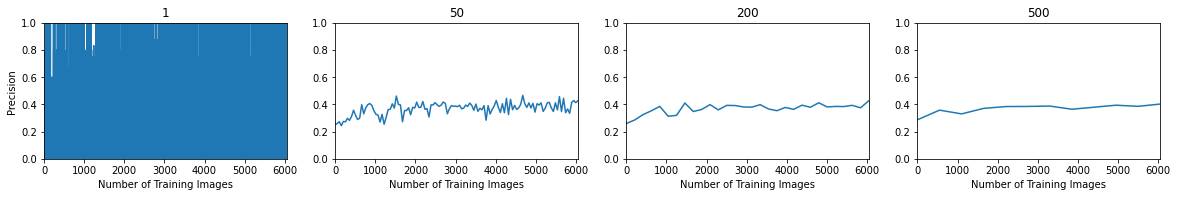

In [76]:
fig, ax = plt.subplots(1, 4, figsize=(20, 2.5))
steps = [1, 50, 200, 500]
for idx, step in enumerate(steps):
  precision = []
  n = int(len(precision_valid)/step)
  for i in range(n):
    precision.append(np.mean(precision_valid[i*step:i*step+step-1]))
  trial = np.linspace(0, len(precision_valid) , len(precision))
  if idx == 0:
    ax[idx].plot(precision_valid)
    ax[idx].set_ylabel('Precision')
  else:
    ax[idx].plot(trial, precision)
  ax[idx].title.set_text(str(step))
  ax[idx].set_ylim([0, 1])
  ax[idx].set_xlim([0, len(precision_valid)])
  ax[idx].set_xlabel('Number of Training Images')

plt.savefig('drive/My Drive/Deep Learning/CS4240-Project/save_figure_rosa/validation_precision.png')


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


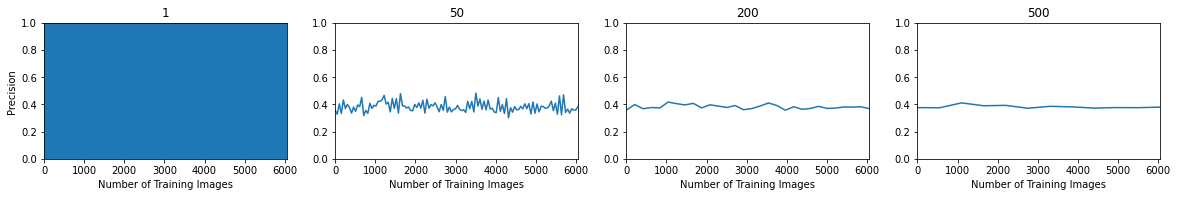

In [77]:
fig, ax = plt.subplots(1, 4, figsize=(20, 2.5))
steps = [1, 50, 200, 500]
for idx, step in enumerate(steps):
  recall_ = []
  n = int(len(recall_valid)/step)
  for i in range(n):
    recall_.append(np.mean(recall_valid[i*step:i*step+step-1]))
  trial = np.linspace(0, len(recall_valid) , len(recall_))
  if idx == 0:
    ax[idx].plot(recall_valid)
    ax[idx].set_ylabel('Precision')
  else:
    ax[idx].plot(trial, recall_)
  ax[idx].title.set_text(str(step))
  ax[idx].set_ylim([0, 1])
  ax[idx].set_xlim([0, len(recall_valid)])
  ax[idx].set_xlabel('Number of Training Images')

plt.savefig('drive/My Drive/Deep Learning/CS4240-Project/save_figure_rosa/validation_recall.png')


In [28]:
load_model = 'drive/My Drive/Deep Learning/CS4240-Project/saved_models_faster_rcnn/correct_run/best.pt'
load_model = 'drive/My Drive/Deep Learning/CS4240-Project/saved_models_faster_rcnn/current.pt'

# Make the differen vectors
loss1_hist_last = []
loss2_hist_last = []
loss_hist_last = []
valid_loss1_hist_last = []
valid_loss2_hist_last = []
valid_loss_hist_last = []

#vgg_feature_extracter, vgg_classifier = Faster_RCNN_vgg16(num_freeze_top=10)
ZF_feature_extracter, ZF_classifier = Faster_RCNN_ZF()
vgg_feature_extracter = ZF_feature_extracter
vgg_classifier = ZF_classifier

rpn = Faster_RCNN_rpn(vgg_feature_extracter).to(device)
ROI_pooling_layer = nn.AdaptiveMaxPool2d(roi_size).to(device)
decider = Faster_RCNN_decider(vgg_classifier).to(device)
all_params = list(list(rpn.parameters()) + list(decider.parameters()))

optimizer = optim.Adam(all_params, lr=0.00005)


# Load in the already existing file
if load_model != '':
  print('loading model ... ')
  checkpoint = torch.load(load_model, map_location=device)
  rpn.load_state_dict(checkpoint['rpn_state_dict'])
  decider.load_state_dict(checkpoint['decider_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  loss1_hist = checkpoint['loss1_hist']
  loss2_hist = checkpoint['loss2_hist']
  loss_hist = checkpoint['loss_hist']
  valid_loss1_hist =checkpoint['valid_loss1_hist']
  valid_loss2_hist = checkpoint['valid_loss2_hist']
  valid_loss_hist = checkpoint['valid_loss_hist']
  epoch_start = checkpoint['epoch_start']
  best_valid_score = checkpoint['best_valid_score']
  precision_train = checkpoint['precision_train']
  recall_train = checkpoint['recall_train']
  precision_valid = checkpoint['precision_valid']
  recall_valid = checkpoint['recall_valid']
  rpn.train()
  decider.train()

  print('model loaded ...' )
else: 
  raise NotImplemented


loading model ... 
model loaded ...


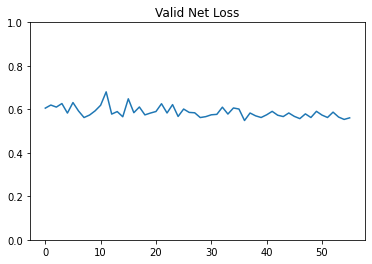

In [50]:
plt.figure()
plt.plot(valid_loss_hist)
plt.title('Valid Net Loss')
plt.ylim([0, 1])
plt.savefig('drive/My Drive/Deep Learning/CS4240-Project/save_figure_rosa/validation_loss.png')

#### Test model on a single image

In [ ]:
rpn.eval()
decider.eval()
print("-------------------------------")
print("Evaluating test sets")

test_loss1_hist = []
test_loss2_hist = []
test_loss_hist = []
test_loss1 = 0
test_loss2 = 0
test_net_loss = 0
test_run_count = 0
test_visualisation = 5
precision_test = []
recall_test = []
for test_idx, test_data in (enumerate(test_loader,0)):
    img, gt_box, labels = test_data
    loss1, loss2, pred_class, pred_box, rpn_pred_box  = single_image_pipeline(img.to(device), gt_box, labels, False)
    net_loss = loss1 + loss2
    
    if not((math.isnan(net_loss)) or (math.isnan(loss1)) or (math.isnan(loss2))):
        test_loss1 += loss1.data
        test_loss2 += loss2.data
        test_net_loss += net_loss.data
        test_run_count += 1


    if (1+ test_idx)%test_visualisation == 0:
      pred_box_nms = test_model(img, gt_box, save_image_='drive/My Drive/Deep Learning/CS4240-Project/save_figure_rosa/test/test_'+str(test_idx), print_ = True)
    else:
      pred_box_nms = test_model(img, gt_box, save_image_='drive/My Drive/Deep Learning/CS4240-Project/save_figure_rosa/test/test_'+str(test_idx), print_ = False)
    
    precision_temp , recall_temp = average_precision(pred_box_nms.cpu(), torch.tensor(gt_box))
    precision_test.append(precision_temp)
    recall_test.append(recall_temp)
    

test_loss1_hist.append(test_loss1/(test_run_count + 1e-6))
test_loss2_hist.append(test_loss2/(test_run_count+ 1e-6))
test_loss_hist.append(test_net_loss/(test_run_count+ 1e-6))


print("-------------------------------")
print("-------------------------------")
print("Test Data Visualise -- ")
print("-------------------------------")
print("-------------------------------")
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 5))
ax1.plot(valid_loss1_hist)
ax1.title.set_text('Valid RPN Loss')
ax2.plot(valid_loss2_hist)
ax2.title.set_text('Valid Decider Loss')
ax3.plot(valid_loss_hist)
ax3.title.set_text('Valid Net Loss')
plt.savefig('drive/My Drive/Deep Learning/CS4240-Project/save_figure_rosa/test/test_loss.png')
